COMP-548DL Final Project - Netflix Big Data Analysis
------------------------
This notebook is the complete project submission and replaces a README.

### Project Pipeline
1. Load Data
2. Clean & Transform (Variety + Veracity)
3. NoSQL Modeling in MongoDB
4. Create Indexes (support Velocity)
5. Batch Analytics with Aggregation
6. Visualizations & Insights

**Big Data Dimensions:** Variety, Veracity, Velocity

Reflection on deviations from the proposal:
------------------------------------------
While my original proposal focused on dataset cleaning, NoSQL ingestion, and analytical
insights, the final project evolved slightly during development.

I introduced additional visualizations (e.g., longest movies, TV shows with the most seasons)
that were not initially planned but added extra value and made the results more interpretable.

I emphasized the three most visible Big Data dimensions (Variety, Veracity, Velocity)
because the dataset made these clearer than the others.

I used MongoDB aggregation pipelines for batch processing instead of adding a streaming
solution, as the dataset did not naturally support real-time ingestion. Focusing on batch
analytics allowed me to go deeper into aggregation, indexing, and query patterns.

These changes did not alter the core objectives but improved clarity, usability, and the
alignment of the project with the real characteristics of the dataset.


Big Data Dimensions in this Netflix dataset:
-------------------------------------------

1. Variety
   - The dataset contains multi-valued fields such as "listed_in" (genres) and "country",
     where a single title can have multiple genres and multiple production countries.
   - The "duration" field mixes different units: movies use minutes (e.g., "90 min")
     whereas TV shows use seasons (e.g., "2 Seasons").
   - The "date_added" field is stored as free-text strings (e.g., "September 9, 2019")
     and must be parsed into a proper datetime type.
   - The data also mixes textual, categorical, numerical, and temporal attributes.

   -> In this project, Variety is handled by:
      - Splitting and normalizing multi-valued fields.
      - Parsing duration into separate numeric value and unit.
      - Using a flexible MongoDB schema with arrays for genres and countries.


2. Veracity
   - The raw dataset contains missing values (e.g., for rating, country, date_added).
   - Some "show_id" entries are duplicated, which can lead to double-counting.
   - The "duration" field can be ambiguous or inconsistently formatted.
   - Generic placeholders such as "Unknown" are necessary after cleaning to indicate
     uncertainty rather than silently dropping rows.

   -> In this project, Veracity is addressed by:
      - Reporting and filling missing values where appropriate.
      - Dropping duplicate records based on show_id.
      - Parsing and standardizing duration strings.
      - Making data quality issues explicit in logs and code comments.


3. Velocity
   - The "date_added" field captures when each title was added to Netflix.
   - By converting this to "year_added", it becomes possible to analyze the growth of
     the catalog over time.
   - Aggregations and visualizations of titles per year added show how the rate of
     new content intake changes across years.

   -> In this project, Velocity is demonstrated by:
      - Creating the "year_added" feature from the original date strings.
      - Plotting the number of titles added per year to show catalog growth.
      - Using MongoDB aggregation pipelines to compute counts by year_added
        as a batch analytics example.

Although all 5Vs of Big Data are relevant conceptually, this dataset most clearly
demonstrates Variety, Veracity, and Velocity. These three dimensions directly influenced
the data cleaning steps, the NoSQL schema design, and the analytic queries implemented
in this code.

# IMPORTS & GLOBAL SETTINGS 

In [2]:
# Import required libraries, set display settings, and define dataset path
import os
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure matplotlib for consistent visuals
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)

# Path to the primary dataset used throughout the project
DATA_PATH = "netflix_titles.csv" 

# BIG DATA CHALLENGES (CONCEPTUAL FUNCTIONS)

In [3]:
# Explain how the Netflix dataset aligns with Big Data concepts (5Vs: Volume, Velocity, Variety, Veracity, Value)
def describe_big_data_for_netflix():
    print("=== Big Data Aspects in the Netflix Dataset ===")

    print("- Variety: The dataset contains multiple data types and formats, including")
    print("  categorical fields, numerical values, free-text descriptions, and multi-valued")
    print("  attributes such as genres and countries, where a single title can belong to")
    print("  multiple categories.")

    print("- Veracity: The raw dataset includes missing values, duplicated identifiers, and")
    print("  inconsistent formatting, especially in fields like duration and date_added,")
    print("  which require cleaning and standardization before analysis.")

    print("- Velocity: The date_added field captures when titles were added to Netflix,")
    print("  allowing analysis of catalog growth over time. Aggregations by year_added")
    print("  show how the rate of new content intake increases significantly after 2017.")

 


# Analyze data quality issues before cleaning (missing values, duplicates, inconsistencies, multi-valued fields)
def summarize_data_quality_issues(raw_data: pd.DataFrame):
    print("\n=== Initial Data Quality / Veracity Overview ===")

    if "rating" in raw_data.columns:
        print("- Missing rating values:", raw_data["rating"].isna().sum())

    if "country" in raw_data.columns:
        print("- Missing country values:", raw_data["country"].isna().sum())

    if "date_added" in raw_data.columns:
        print("- Missing date_added values:", raw_data["date_added"].isna().sum())

    if "duration" in raw_data.columns:
        print("- Examples of duration representations (first 20 unique):")
        print(raw_data["duration"].dropna().unique()[:20])

    print("\n- Multi-valued attributes such as 'listed_in' (genres) and 'country' must be")
    print("  normalized and split before performing reliable analysis.")

    if "listed_in" in raw_data.columns:
        distinct_genre_count = (
            raw_data["listed_in"]
            .dropna()
            .str.split(",")
            .explode()
            .str.strip()
            .nunique())
        print("\n- Number of distinct genres (after splitting):", distinct_genre_count)

    if "show_id" in raw_data.columns:
        duplicate_show_ids = raw_data["show_id"].duplicated().sum()
        print(f"- Duplicate show_id entries detected: {duplicate_show_ids}")

    print("==============================================================\n")


# LOADING & BASIC INSPECTION   

In [4]:
# Load the raw Netflix dataset, verify file exists, preview structure, and report missing values
def load_raw_dataset(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Could not find {path}. Please adjust DATA_PATH.")
    raw_data = pd.read_csv(path)
    print("Raw data shape:", raw_data.shape)
    print("\nRaw preview:")
    print(raw_data.head(20))
    print("\nMissing values (top 20):")
    print(raw_data.isna().sum().sort_values(ascending=False).head(20))
    return raw_data

# Cleaning, Transformation, Grouping + Visualizations

In [5]:
# Convert mixed duration formats (e.g. "90 min", "2 Seasons") into numeric value + unit for analysis
def parse_duration_string(value):
    if pd.isna(value):
        return np.nan, np.nan
    parts = str(value).split()
    if len(parts) != 2:
        return np.nan, np.nan
    try:
        numeric_value = int(parts[0])
    except ValueError:
        return np.nan, parts[1].lower()
    unit = parts[1].lower()
    return numeric_value, unit

# Clean and transform the dataset: remove duplicates, fix missing values, normalize fields, 
# parse dates and durations, and prepare data for analysis & MongoDB storage
def clean_transform_and_explore(raw_data: pd.DataFrame) -> pd.DataFrame:
    table = raw_data.copy()

    # Remove duplicate titles based on show_id to avoid double counting
    if "show_id" in table.columns:
        table = table.drop_duplicates(subset=["show_id"])
    else:
        table = table.drop_duplicates()

    # Parse date_added and extract year (Velocity)
    if "date_added" in table.columns:
        table["date_added"] = pd.to_datetime(table["date_added"], errors="coerce")
        table["year_added"] = table["date_added"].dt.year 

    # Fill missing categorical values to maintain dataset integrity
    if "country" in table.columns:
        table["country"] = table["country"].fillna("Unknown")
        
    if "rating" in table.columns:
        table["rating"] = table["rating"].fillna("Unknown")
        
    if "listed_in" in table.columns:
        table["listed_in"] = table["listed_in"].fillna("Unknown")

    # Parse duration into numeric value + unit that needed for comparing movies & shows
    if "duration" in table.columns:
        parsed_duration = table["duration"].apply(parse_duration_string)
        table["duration_value"] = parsed_duration.apply(lambda x: x[0])
        table["duration_unit"] = parsed_duration.apply(lambda x: x[1])

    # Normalize multi-value strings (genres and countries) (Variety)
    if "listed_in" in table.columns:
        table["listed_in"] = table["listed_in"].apply(
            lambda s: ",".join([genre.strip() for genre in str(s).split(",")]))
        
    if "country" in table.columns:
        table["country"] = table["country"].apply(
            lambda s: ",".join([country.strip() for country in str(s).split(",")]))
        
    # Preview cleaned dataset status
    print("\nCleaned data preview:")
    print(table.head(20))
    print("\nMissing values after cleaning (top 20):")
    print(table.isna().sum().sort_values(ascending=False).head(20))

    # ========================================================================
    # Exploratory Data Analysis (EDA) — Insights & Visualizations
    #    - Movies vs TV Shows distribution
    #    - Growth over time (Velocity)
    #    - Top countries & genres (Variety)
    # ========================================================================
    print("\n=== Exploratory Insights from the Cleaned Data ===")

    # Count of Movies vs TV Shows
    if "type" in table.columns:
        type_counts = table["type"].value_counts()
        print("\nCount of titles by type:")
        print(type_counts)

        type_counts.plot(kind="bar")
        plt.title("Count of Titles by Type")
        plt.xlabel("Type")
        plt.ylabel("Number of Titles")
        plt.tight_layout()
        plt.savefig("movies_vs_tv.png", dpi=300, bbox_inches="tight")
        plt.show()

    # Titles per release year
    if "release_year" in table.columns:
        titles_per_year = table["release_year"].value_counts().sort_index()
        print("\nTitles per release year (last 20 years):")
        print(titles_per_year.tail(20))

        titles_per_year.tail(20).plot(kind="bar")
        plt.title("Number of Titles per Release Year (Last 20 Years)")
        plt.xlabel("Release Year")
        plt.ylabel("Number of Titles")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Titles per year added to Netflix (Velocity dimension)
    if "year_added" in table.columns:
        titles_per_year_added = (
            table["year_added"]
            .dropna()
            .astype("Int64")
            .value_counts()
            .sort_index())
        print("\nTitles per year added to Netflix (catalog growth – last 20 years):")
        print(titles_per_year_added.tail(20))

        titles_per_year_added.tail(20).plot(kind="bar")
        plt.title("Number of Titles per Year Added to Netflix (Last 20 Years)")
        plt.xlabel("Year Added")
        plt.ylabel("Number of Titles Added")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Top 20 producing countries
    if "country" in table.columns:
        country_view = table.assign(
            first_country=table["country"].str.split(",").str[0])
        top_countries = country_view["first_country"].value_counts().head(20)
        print("\nTop 20 countries by number of titles (based on first listed country):")
        print(top_countries)

        top_countries.plot(kind="bar")
        plt.title("Top 20 Countries by Number of Titles")
        plt.xlabel("Country")
        plt.ylabel("Number of Titles")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Top 20 genres
    if "listed_in" in table.columns:
        genre_table = (
            table[["show_id", "title", "type", "release_year", "listed_in"]]
            .assign(genre=lambda data: data["listed_in"].str.split(","))
            .explode("genre"))
        genre_table["genre"] = genre_table["genre"].str.strip()
        top_genres = genre_table["genre"].value_counts().head(20)
        print("\nTop 20 genres by number of titles:")
        print(top_genres)

        top_genres.plot(kind="bar")
        plt.title("Top 20 Genres by Number of Titles")
        plt.xlabel("Genre")
        plt.ylabel("Number of Titles")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    print("==========================================================\n")

    return table


# MongoDB Setup & Ingestion (NoSQL model)

In [6]:
# Initialize and validate MongoDB connection; returns client and database instance for further operations
def initialize_mongo_connection():
    try:
        from pymongo import MongoClient
    except ImportError:
        print("pymongo is not installed. Install it with: pip install pymongo")
        return None, None

    client = MongoClient("mongodb://localhost:27017", serverSelectionTimeoutMS=5000)
    try:
        client.admin.command("ping")
        print("\nSuccessfully connected to MongoDB.")
        db = client["netflix_db"]
        return client, db
    except Exception as e:
        print("Could not connect to MongoDB server:", e)
        return None, None

# Ingest cleaned data into MongoDB: build the 'titles' collection, convert fields to arrays, 
# and create indexes that support efficient analytical queries
def populate_titles_collection(db, prepared_table: pd.DataFrame):

    # Create or access main collection for Netflix titles
    titles_collection = db["titles"]

    # Clear existing documents to avoid duplicates from previous runs
    titles_collection.delete_many({})

    # Define fields to include in MongoDB documents (NoSQL schema)
    # 'year_added' is included to analyze catalog growth over time (Velocity)
    required_columns = [
        "show_id",
        "type",
        "title",
        "release_year",
        "year_added",     
        "listed_in",
        "country",
        "rating",
        "duration_value",
        "duration_unit",]
    
    # Keep only columns that exist in the cleaned Dataframe
    existing_columns = [c for c in required_columns if c in prepared_table.columns]
    titles_table = prepared_table[existing_columns].copy()

    # Remove any leftover duplicates just to be safe
    if "show_id" in titles_table.columns:
        titles_table = titles_table.drop_duplicates(subset=["show_id"])
    else:
        titles_table = titles_table.drop_duplicates()

    # Convert comma-separated strings → arrays for MongoDB storage
    if "listed_in" in titles_table.columns:
        titles_table["listed_in"] = titles_table["listed_in"].astype(str).apply(
            lambda x: [g.strip() for g in x.split(",")] if x.strip() != "" else ["Unknown"])
        
    if "country" in titles_table.columns:
        titles_table["country"] = titles_table["country"].astype(str).apply(
            lambda x: [c.strip() for c in x.split(",")] if x.strip() != "" else ["Unknown"])

    # Insert records into the collection
    records = titles_table.to_dict(orient="records")
    if records:
        titles_collection.insert_many(records)

    # Create indexes to improve query and aggregation performance
    if "release_year" in titles_table.columns:
        titles_collection.create_index([("release_year", 1)])
        
    if "year_added" in titles_table.columns:
        titles_collection.create_index([("year_added", 1)])
        
    if "country" in titles_table.columns:
        titles_collection.create_index([("country", 1)])
        
    if "listed_in" in titles_table.columns:
        titles_collection.create_index([("listed_in", 1)])

    # Optional indexes for deeper analytics
    if "type" in titles_table.columns and "release_year" in titles_table.columns:
        titles_collection.create_index([("type", 1), ("release_year", 1)])
        
    if "title" in titles_table.columns:
        titles_collection.create_index([("title", "text")])

    print(f"\nInserted {len(records)} documents into 'titles' collection.")
    print(
        "Indexes on release_year, year_added, country, listed_in, (type, release_year), "
        "and text(title) created (where applicable).")

    return titles_collection


# Example MongoDB Queries for Data Extraction

In [7]:
# Run sample MongoDB queries to validate schema and perform basic data exploration.
# Demonstrates filtering by: country, genre & year range (Velocity), duration, and array fields (Variety)
def execute_example_queries(titles_collection):
    print("\n=== Sample MongoDB Queries ===")

    # Filter by country (simple equality match) 
    country = "United States"
    print(f"\nSome titles produced in {country}:")
    cursor = (
        titles_collection.find({"country": country})
        .sort("release_year", -1)
        .limit(20))
    for doc in cursor:
        print(doc.get("release_year"), "-", doc.get("title"), f"({doc.get('type')})")

    # Filter by genre + time range → demonstrates Velocity & historical filtering
    genre = "Comedies"
    start_year = 2015
    end_year = 2020
    print(f"\nSome {genre} titles released between {start_year} and {end_year}:")
    cursor = (
        titles_collection.find(
            {
                "listed_in": genre,
                "release_year": {"$gte": start_year, "$lte": end_year},})
        .sort("release_year", -1)
        .limit(20))
    
    for doc in cursor:
        print(doc.get("release_year"), "-", doc.get("title"), "-", doc.get("country"))

    # Filter by parsed duration → enabled by cleaning step that splits numeric + unit
    print("\nSome long movies (duration >= 120 minutes):")
    cursor = (
        titles_collection.find(
            {
                "type": "Movie",
                "duration_unit": "min",
                "duration_value": {"$gte": 120},})
        .sort("duration_value", -1)
        .limit(20))
    
    for doc in cursor:
        print(f"{doc.get('title')} - {doc.get('duration_value')} {doc.get('duration_unit')}")

    # Multi-country productions: checks for second array element to demonstrate Variety handling
    print("\nSome titles produced in more than one country:")
    cursor = (
        titles_collection.find(
            {
                "country.1": {"$exists": True} 
            })
        .limit(20))
    
    for doc in cursor:
        print(doc.get("title"), "->", doc.get("country"))

    print("\n=== End of sample queries ===\n")

# Big Data Processing: Batch Analytics via Aggregation Pipelines and Plots

In [8]:
# Run batch analytics using MongoDB aggregation pipelines:
# compute catalog growth (Velocity), top genres/countries (Variety), rating distribution,
# and duration-based rankings for movies and TV shows.
def execute_batch_analytics(titles_collection):
    print("\n=== Batch Analytics using MongoDB Aggregation ===")

    # Titles per release year (content production trend over time)
    pipeline_titles_per_year = [
        {"$match": {"release_year": {"$ne": None}}},
        {"$group": {"_id": "$release_year", "title_count": {"$sum": 1}}},
        {"$sort": {"_id": 1}},]
    
    results_year = list(titles_collection.aggregate(pipeline_titles_per_year))
    print("\nTitles per release year (first 20 years in result):")
    
    for doc in results_year[:20]:
        print(f"Year {doc['_id']}: {doc['title_count']} titles")

    if results_year:
        yearly_stats = pd.DataFrame(results_year).rename(columns={"_id": "release_year"})
        plt.plot(yearly_stats["release_year"], yearly_stats["title_count"], marker="o")
        plt.title("Titles per Release Year (MongoDB Aggregation)")
        plt.xlabel("Release Year")
        plt.ylabel("Number of Titles")
        plt.tight_layout()
        plt.show()

    # Titles per year added to Netflix (Velocity: catalog intake rate)
    pipeline_titles_per_year_added = [
        {"$match": {"year_added": {"$ne": None}}},
        {"$group": {"_id": "$year_added", "title_count": {"$sum": 1}}},
        {"$sort": {"_id": 1}},]
    
    results_year_added = list(titles_collection.aggregate(pipeline_titles_per_year_added))
    print("\nTitles per year added to Netflix (first 20 years in result):")
    
    for doc in results_year_added[:20]:
        print(f"Year added {doc['_id']}: {doc['title_count']} titles")

    if results_year_added:
        year_added_stats = pd.DataFrame(results_year_added).rename(columns={"_id": "year_added"})
        plt.plot(year_added_stats["year_added"], year_added_stats["title_count"], marker="o")
        plt.title("Titles per Year Added to Netflix (MongoDB Aggregation)")
        plt.xlabel("Year Added")
        plt.ylabel("Number of Titles Added")
        plt.tight_layout()
        plt.savefig("titles_per_year_added_mongo.png", dpi=300)
        plt.show()

    # Top 20 genres (Variety: unwind multi-valued 'listed_in')
    pipeline_top_genres = [
        {"$unwind": "$listed_in"},
        {"$group": {"_id": "$listed_in", "title_count": {"$sum": 1}}},
        {"$sort": {"title_count": -1}},
        {"$limit": 20},]
    
    results_genres = list(titles_collection.aggregate(pipeline_top_genres))
    print("\nTop 20 genres (MongoDB aggregation):")
    
    for doc in results_genres:
        print(f"{doc['_id']}: {doc['title_count']} titles")

    if results_genres:
        genre_stats = pd.DataFrame(results_genres).rename(columns={"_id": "genre"})
        genre_stats.set_index("genre")["title_count"].plot(kind="bar")
        plt.title("Top 20 Genres (MongoDB Aggregation)")
        plt.xlabel("Genre")
        plt.ylabel("Number of Titles")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("top_genres_mongo.png", dpi=300)
        plt.show()

    # Top 20 countries (Variety: 'country' stored as an array)
    pipeline_top_countries = [
        {"$unwind": "$country"},
        {"$group": {"_id": "$country", "title_count": {"$sum": 1}}},
        {"$sort": {"title_count": -1}},
        {"$limit": 20},]
    
    results_countries = list(titles_collection.aggregate(pipeline_top_countries))
    print("\nTop 20 countries (MongoDB aggregation):")
    
    for doc in results_countries:
        print(f"{doc['_id']}: {doc['title_count']} titles")

    if results_countries:
        country_stats = pd.DataFrame(results_countries).rename(columns={"_id": "country"})
        country_stats.set_index("country")["title_count"].plot(kind="bar")
        plt.title("Top 20 Countries (MongoDB Aggregation)")
        plt.xlabel("Country")
        plt.ylabel("Number of Titles")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("top_20_countries_mongo.png", dpi=300)
        plt.show()

    # Titles per rating (content maturity distribution)
    pipeline_rating = [
        {"$match": {"rating": {"$ne": None}}},
        {"$group": {"_id": "$rating", "title_count": {"$sum": 1}}},
        {"$sort": {"title_count": -1}},]
    
    results_rating = list(titles_collection.aggregate(pipeline_rating))
    print("\nTitles per rating (sorted):")
        
    for doc in results_rating[:20]:
        print(f"{doc['_id']}: {doc['title_count']} titles")

    if results_rating:
        rating_stats = pd.DataFrame(results_rating).rename(columns={"_id": "rating"})
        rating_stats.set_index("rating")["title_count"].plot(kind="bar")
        plt.title("Titles per Rating (MongoDB Aggregation)")
        plt.xlabel("Rating")
        plt.ylabel("Number of Titles")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # Ranking: top N longest movies
    N = 20
    pipeline_longest_movies = [
        {"$match": {"type": "Movie", "duration_unit": "min", "duration_value": {"$ne": None}}},
        {"$sort": {"duration_value": -1}},
        {"$limit": N},
        {"$project": {"_id": 0, "title": 1, "duration_value": 1}},]
    
    longest_movies = list(titles_collection.aggregate(pipeline_longest_movies))

    if longest_movies:
        df_movies = pd.DataFrame(longest_movies).rename(columns={"duration_value": "minutes"})
        df_movies = df_movies.sort_values("minutes", ascending=True)
        df_movies.set_index("title")["minutes"].plot(kind="barh")
        plt.title(f"Top {N} Longest Movies on Netflix (minutes)")
        plt.xlabel("Minutes")
        plt.ylabel("Movie Title")
        plt.tight_layout()
        plt.savefig("longest_movies_mongo.png", dpi=300)
        plt.show()
    else:
        print("No movie data found for longest-movies plot.")


    # Ranking: top N TV shows by number of seasons
    pipeline_most_seasons_tv = [
        {"$match": {"type": "TV Show", "duration_unit": {"$in": ["season", "seasons"]}, "duration_value": {"$ne": None}}},
        {"$sort": {"duration_value": -1}},
        {"$limit": N},
        {"$project": {"_id": 0, "title": 1, "duration_value": 1}},]
    
    most_seasons_tv = list(titles_collection.aggregate(pipeline_most_seasons_tv))

    if most_seasons_tv:
        df_tv = pd.DataFrame(most_seasons_tv).rename(columns={"duration_value": "seasons"})
        df_tv = df_tv.sort_values("seasons", ascending=True)

        df_tv.set_index("title")["seasons"].plot(kind="barh")
        plt.title(f"Top {N} TV Shows with Most Seasons on Netflix")
        plt.xlabel("Seasons")
        plt.ylabel("TV Show Title")
        plt.tight_layout()
        plt.savefig("most_seasons_tv_mongo.png", dpi=300)
        plt.show()
    else:
        print("No TV show data found for most-seasons plot.")


    # Average duration per type (Movies vs TV Shows)
    pipeline_avg_duration = [
        {
            "$match": {
                "duration_value": {"$ne": None},
                "type": {"$in": ["Movie", "TV Show"]},
                "duration_unit": {"$in": ["min", "season", "seasons"]},}},
        {
            "$addFields": {
                "duration_unit_norm": {
                    "$cond": [
                        {"$in": ["$duration_unit", ["season", "seasons"]]},
                        "seasons",
                        "$duration_unit"]}}},
        {
            "$group": {
                "_id": {"type": "$type", "unit": "$duration_unit_norm"},
                "avg_duration": {"$avg": "$duration_value"},
                "count": {"$sum": 1},}},
        {"$sort": {"_id.type": 1}}]


    results_avg_duration = list(titles_collection.aggregate(pipeline_avg_duration))

    print("\nAverage duration by type:")
    
    for doc in results_avg_duration:
        print(
            f"{doc['_id']['type']} ({doc['_id']['unit']}): "
            f"{doc['avg_duration']:.1f} (n={doc['count']})")

    if results_avg_duration:
        duration_stats = pd.DataFrame(results_avg_duration)
        duration_stats["type"] = duration_stats["_id"].apply(lambda x: x["type"])
        duration_stats["unit"] = duration_stats["_id"].apply(lambda x: x["unit"])

        movie = duration_stats[(duration_stats["type"] == "Movie") & (duration_stats["unit"] == "min")]
        tv = duration_stats[(duration_stats["type"] == "TV Show") & (duration_stats["unit"] == "seasons")]

        if not movie.empty:
            movie.set_index("type")["avg_duration"].plot(kind="bar")
            plt.title("Average Movie Duration (minutes) - MongoDB")
            plt.xlabel("Type")
            plt.ylabel("Minutes")
            plt.tight_layout()
            plt.show()

        if not tv.empty:
            tv.set_index("type")["avg_duration"].plot(kind="bar")
            plt.title("Average TV Show Duration (seasons) - MongoDB")
            plt.xlabel("Type")
            plt.ylabel("Seasons")
            plt.tight_layout()
            plt.show()


# Main Pipeline  

=== Big Data Aspects in the Netflix Dataset ===
- Variety: The dataset contains multiple data types and formats, including
  categorical fields, numerical values, free-text descriptions, and multi-valued
  attributes such as genres and countries, where a single title can belong to
  multiple categories.
- Veracity: The raw dataset includes missing values, duplicated identifiers, and
  inconsistent formatting, especially in fields like duration and date_added,
  which require cleaning and standardization before analysis.
- Velocity: The date_added field captures when titles were added to Netflix,
  allowing analysis of catalog growth over time. Aggregations by year_added
  show how the rate of new content intake increases significantly after 2017.
Raw data shape: (8807, 12)

Raw preview:
   show_id     type                                              title  \
0       s1    Movie                               Dick Johnson Is Dead   
1       s2  TV Show                                   

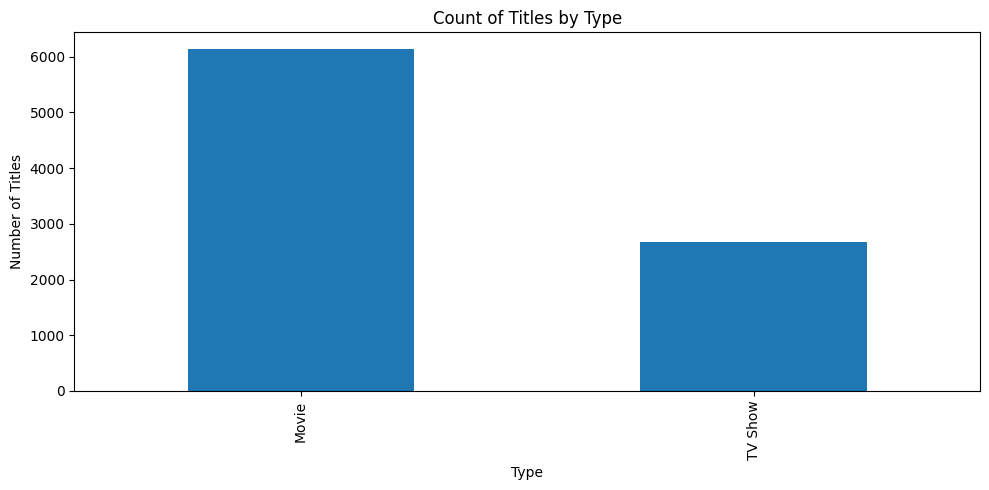


Titles per release year (last 20 years):
release_year
2002      51
2003      61
2004      64
2005      80
2006      96
2007      88
2008     136
2009     152
2010     194
2011     185
2012     237
2013     288
2014     352
2015     560
2016     902
2017    1032
2018    1147
2019    1030
2020     953
2021     592
Name: count, dtype: int64


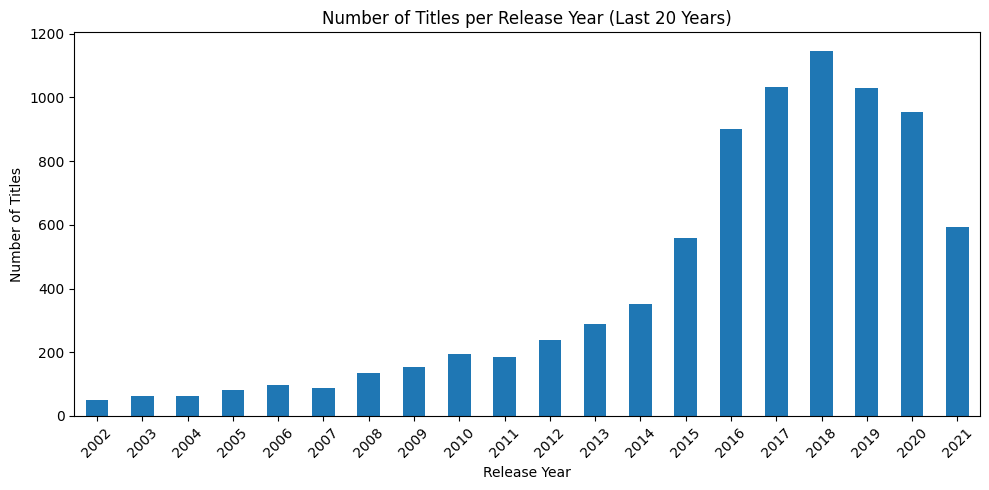


Titles per year added to Netflix (catalog growth – last 20 years):
year_added
2008       2
2009       2
2010       1
2011      13
2012       3
2013      10
2014      23
2015      73
2016     418
2017    1164
2018    1625
2019    1999
2020    1878
2021    1498
Name: count, dtype: Int64


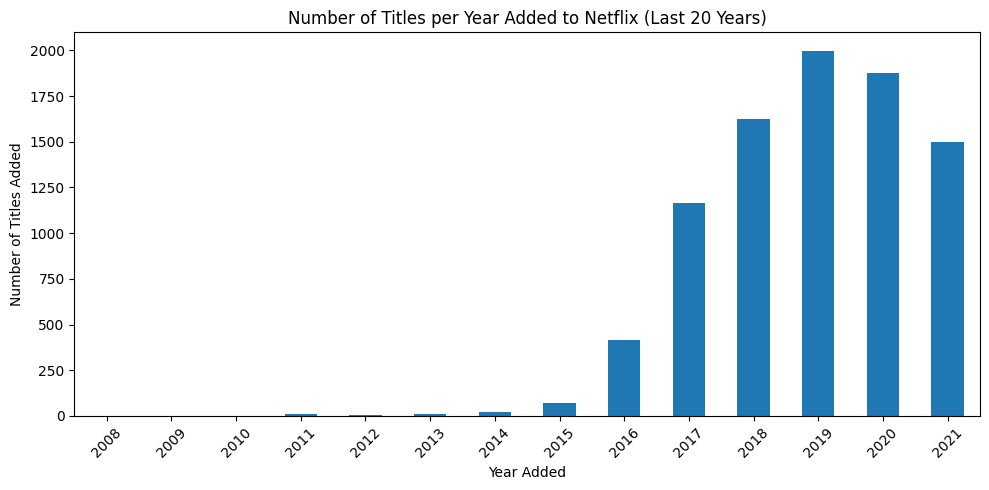


Top 20 countries by number of titles (based on first listed country):
first_country
United States     3211
India             1008
Unknown            831
United Kingdom     628
Canada             271
Japan              259
France             212
South Korea        211
Spain              181
Mexico             134
Australia          117
Egypt              112
Turkey             111
Germany            103
China              100
Nigeria             96
Taiwan              85
Indonesia           85
Brazil              84
Philippines         80
Name: count, dtype: int64


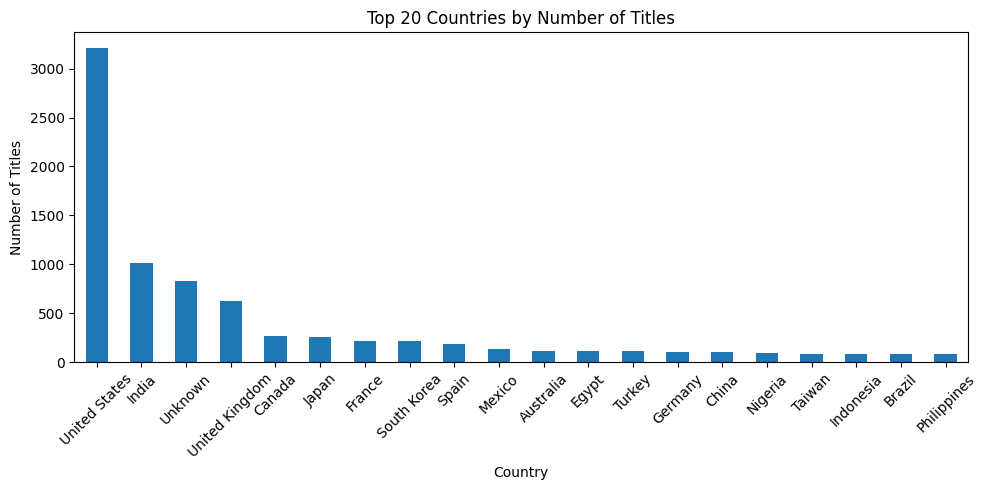


Top 20 genres by number of titles:
genre
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Music & Musicals             375
Romantic TV Shows            370
Horror Movies                357
Stand-Up Comedy              343
Reality TV                   255
Name: count, dtype: int64


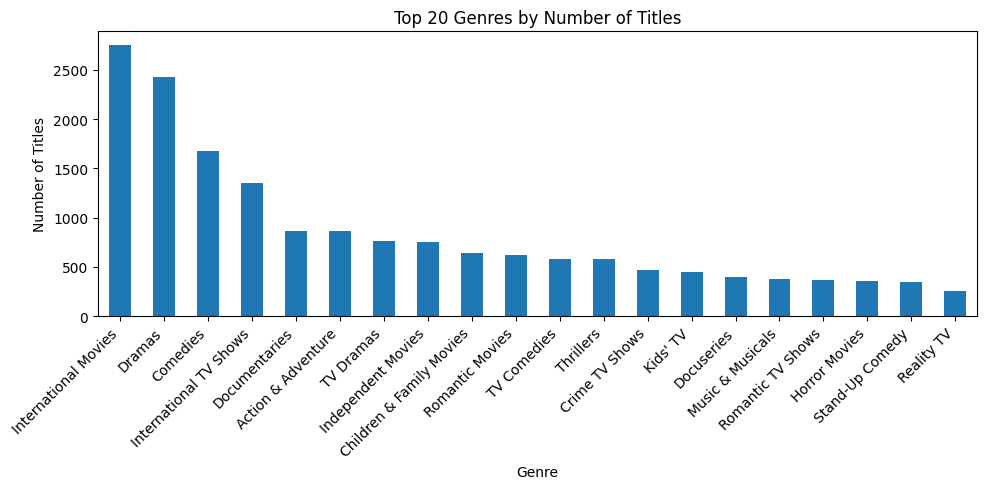



Successfully connected to MongoDB.

Inserted 8807 documents into 'titles' collection.
Indexes on release_year, year_added, country, listed_in, (type, release_year), and text(title) created (where applicable).

=== Sample MongoDB Queries ===

Some titles produced in United States:
2021 - The Netflix Afterparty (TV Show)
2021 - Love Is Blind (TV Show)
2021 - Polly Pocket (TV Show)
2021 - Hilda (TV Show)
2021 - The Minimalists: Less Is Now (Movie)
2021 - Headspace Guide to Meditation (TV Show)
2021 - Dream Home Makeover (TV Show)
2021 - Cobra Kai (TV Show)
2021 - Nailed It! Mexico (TV Show)
2021 - History of Swear Words (TV Show)
2021 - Surviving Death (TV Show)
2021 - Pretend It’s a City (TV Show)
2021 - Creating The Queen's Gambit (Movie)
2021 - Charming (Movie)
2021 - Crack: Cocaine, Corruption & Conspiracy (Movie)
2021 - Night Stalker: The Hunt for a Serial Killer (TV Show)
2021 - What Would Sophia Loren Do? (Movie)
2021 - Outside the Wire (Movie)
2021 - Disenchantment (TV Show)
202

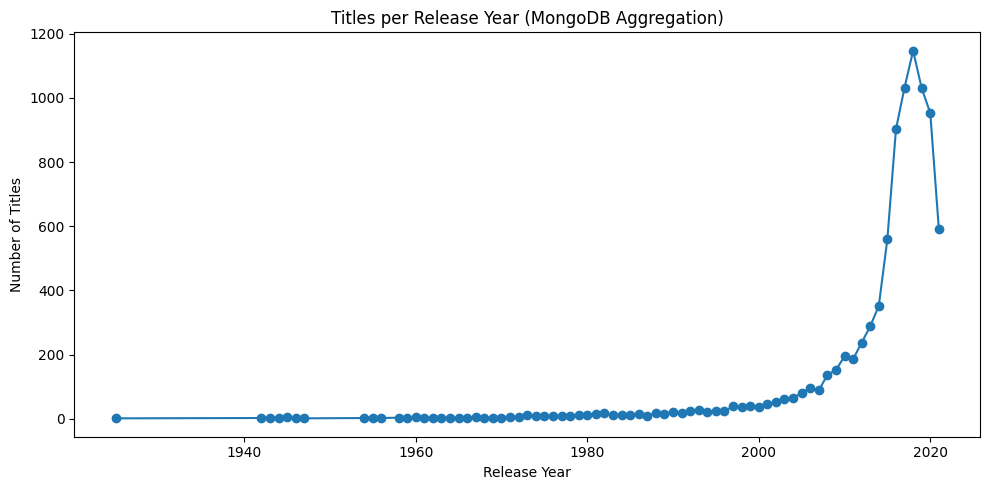


Titles per year added to Netflix (first 20 years in result):
Year added nan: 98 titles
Year added 2008.0: 2 titles
Year added 2009.0: 2 titles
Year added 2010.0: 1 titles
Year added 2011.0: 13 titles
Year added 2012.0: 3 titles
Year added 2013.0: 10 titles
Year added 2014.0: 23 titles
Year added 2015.0: 73 titles
Year added 2016.0: 418 titles
Year added 2017.0: 1164 titles
Year added 2018.0: 1625 titles
Year added 2019.0: 1999 titles
Year added 2020.0: 1878 titles
Year added 2021.0: 1498 titles


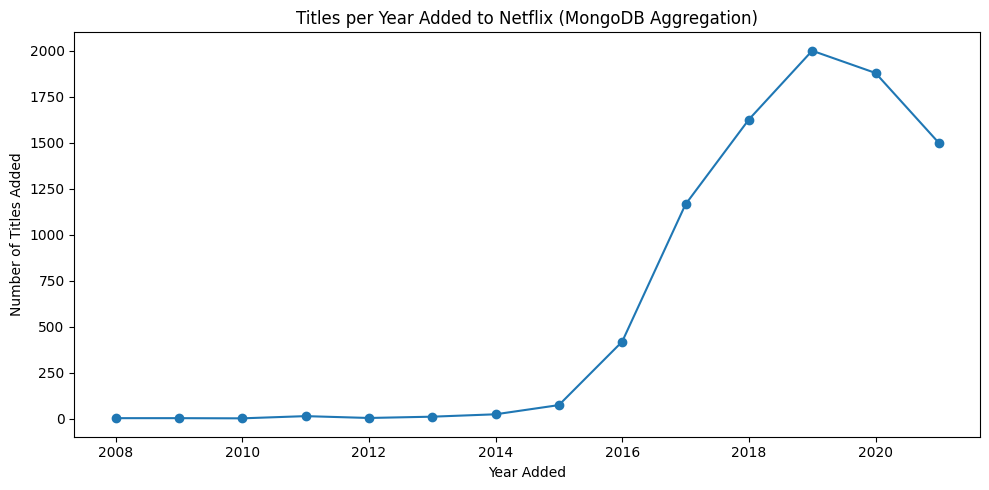


Top 20 genres (MongoDB aggregation):
International Movies: 2752 titles
Dramas: 2427 titles
Comedies: 1674 titles
International TV Shows: 1351 titles
Documentaries: 869 titles
Action & Adventure: 859 titles
TV Dramas: 763 titles
Independent Movies: 756 titles
Children & Family Movies: 641 titles
Romantic Movies: 616 titles
TV Comedies: 581 titles
Thrillers: 577 titles
Crime TV Shows: 470 titles
Kids' TV: 451 titles
Docuseries: 395 titles
Music & Musicals: 375 titles
Romantic TV Shows: 370 titles
Horror Movies: 357 titles
Stand-Up Comedy: 343 titles
Reality TV: 255 titles


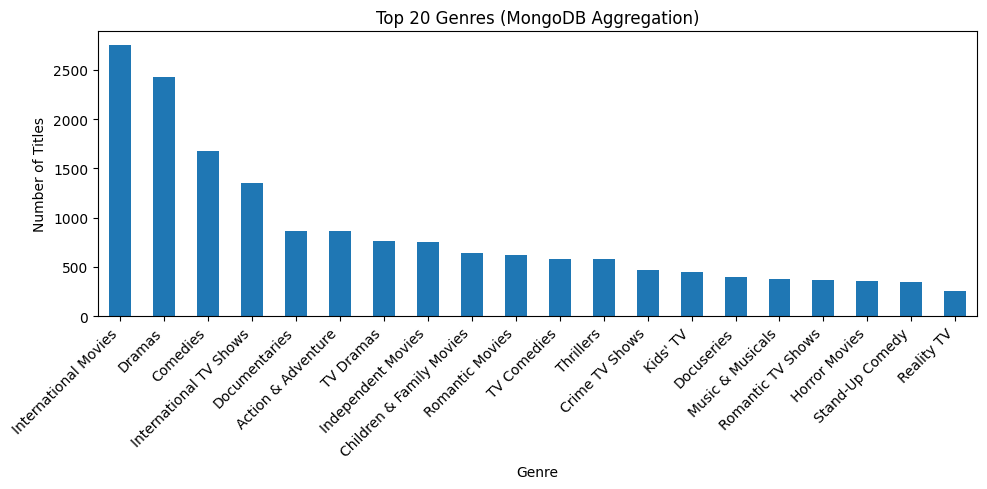


Top 20 countries (MongoDB aggregation):
United States: 3690 titles
India: 1046 titles
Unknown: 831 titles
United Kingdom: 806 titles
Canada: 445 titles
France: 393 titles
Japan: 318 titles
Spain: 232 titles
South Korea: 231 titles
Germany: 226 titles
Mexico: 169 titles
China: 162 titles
Australia: 160 titles
Egypt: 117 titles
Turkey: 113 titles
Hong Kong: 105 titles
Nigeria: 103 titles
Italy: 100 titles
Brazil: 97 titles
Argentina: 91 titles


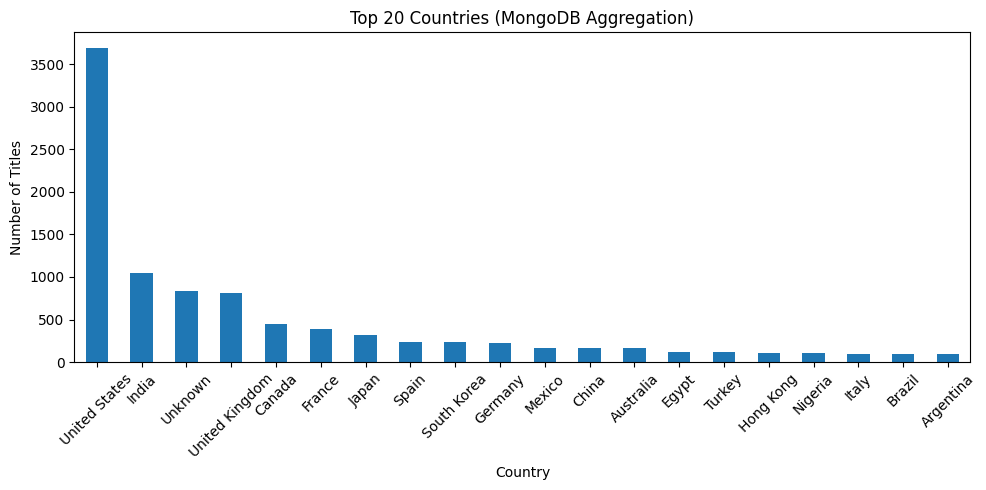


Titles per rating (sorted):
TV-MA: 3207 titles
TV-14: 2160 titles
TV-PG: 863 titles
R: 799 titles
PG-13: 490 titles
TV-Y7: 334 titles
TV-Y: 307 titles
PG: 287 titles
TV-G: 220 titles
NR: 80 titles
G: 41 titles
TV-Y7-FV: 6 titles
Unknown: 4 titles
NC-17: 3 titles
UR: 3 titles
66 min: 1 titles
74 min: 1 titles
84 min: 1 titles


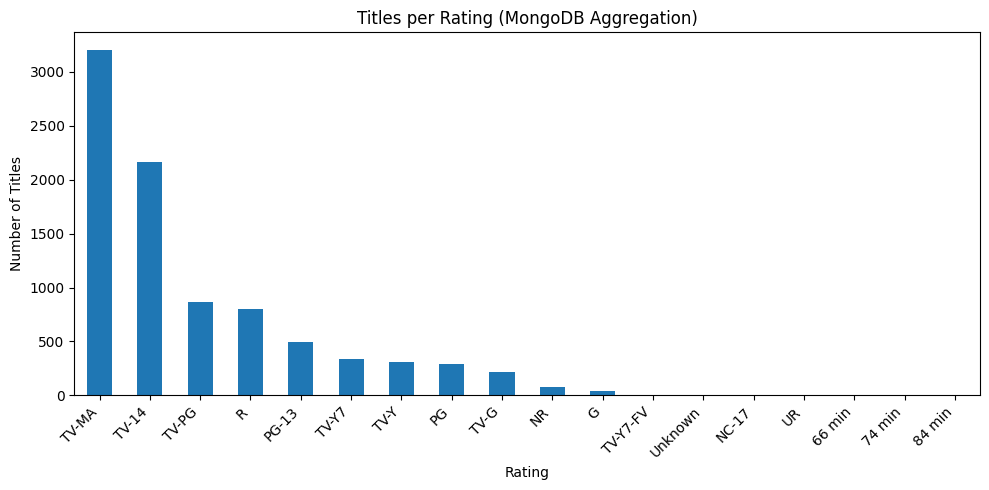

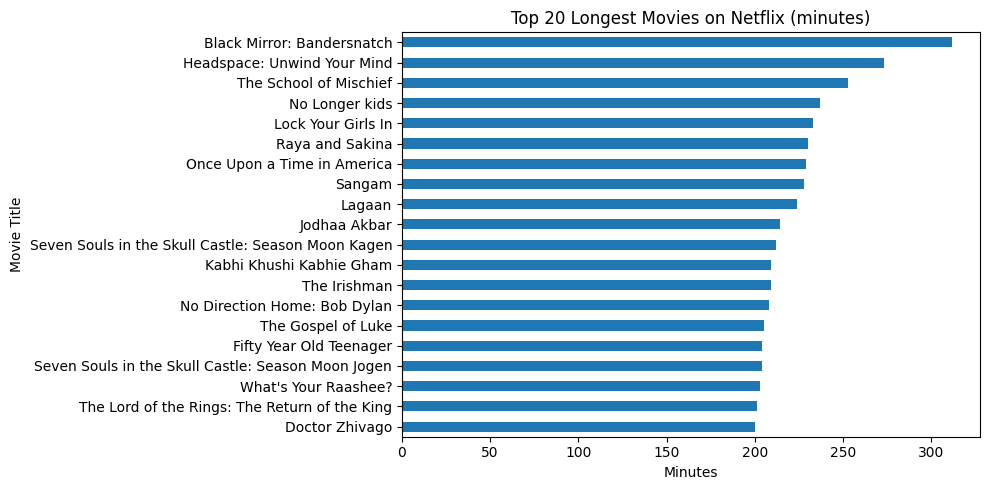

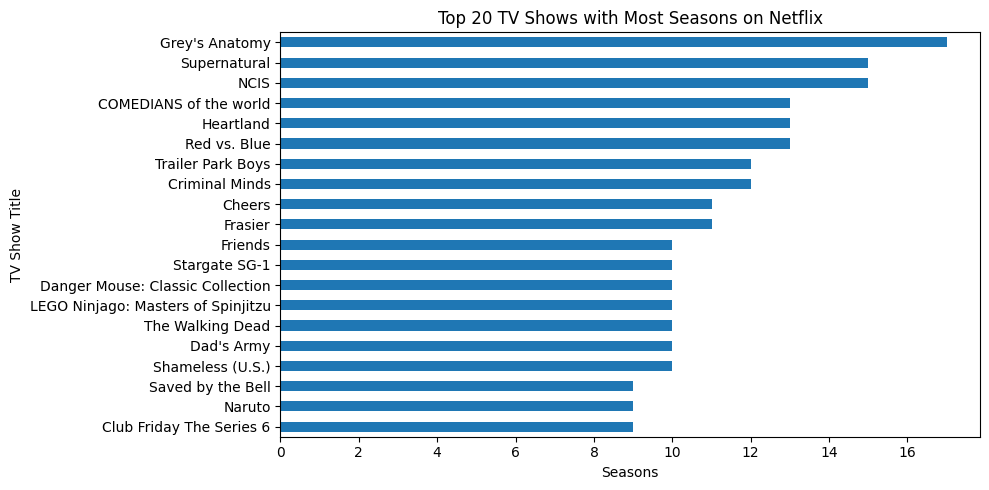


Average duration by type:
Movie (min): 99.6 (n=6128)
TV Show (seasons): 1.8 (n=2676)


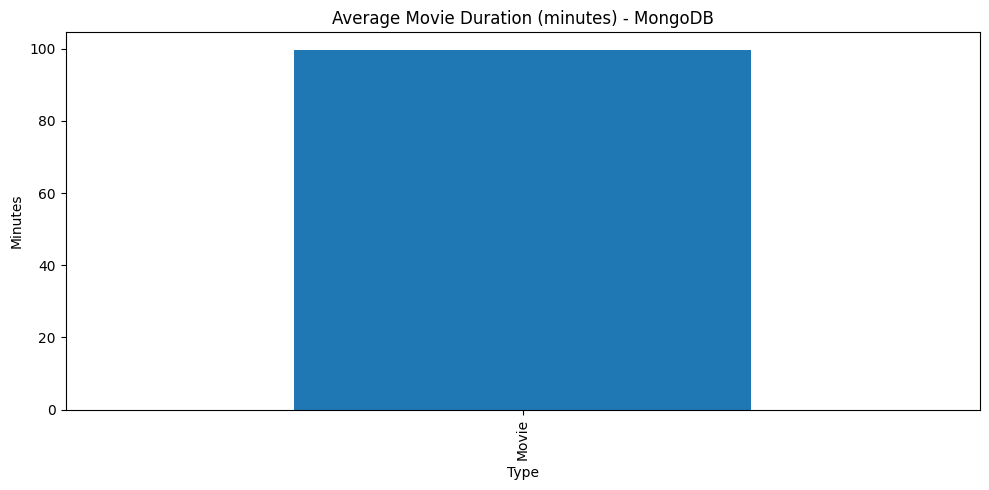

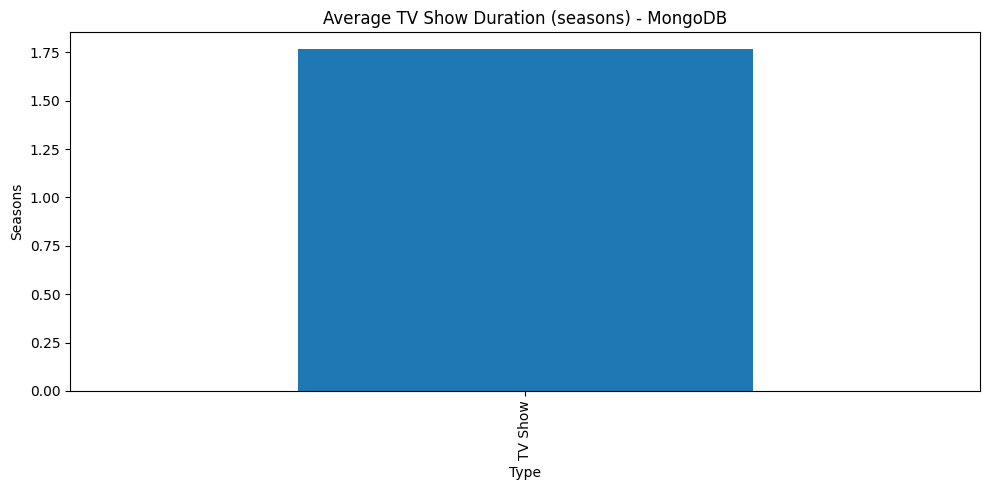

In [9]:
# Execute the full project pipeline:
#    - Describe Big Data context
#    - Load and inspect raw data
#    - Clean and transform dataset
#    - Ingest into MongoDB (NoSQL model)
#    - Run example queries and batch analytics
def run_project_pipeline():
    # Big Data challenges (conceptual)
    describe_big_data_for_netflix()

    # Load raw data
    raw_data = load_raw_dataset(DATA_PATH)

    # Show dataset-specific veracity / quality issues
    summarize_data_quality_issues(raw_data)

    # Clean, transform, group and print analytic insights (pandas) + visualizations
    prepared_data = clean_transform_and_explore(raw_data)

    # Setup MongoDB
    client, db = initialize_mongo_connection()
    if db is None:
        print("MongoDB not available. Skipping NoSQL parts.")
        return

    # Ingest cleaned data into MongoDB
    titles_collection = populate_titles_collection(db, prepared_data)

    # Run relevant queries for data extraction
    execute_example_queries(titles_collection)

    # Run batch analytics (Big Data processing solution) + visualizations
    execute_batch_analytics(titles_collection)

    


if __name__ == "__main__":
    run_project_pipeline()